<a href="https://colab.research.google.com/github/Buyan-Kirill/practice-VTM-sem-8/blob/main/Tensors_task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\Large{Levenberg-Marquardt}$

In [1]:
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from itertools import accumulate

# Развёртка тензора
def unfold(tensor, ax=0):
    if ax < 0 or ax >= len(tensor.shape):
        raise ValueError("Недопустимый номер направления")
    tensor_1 = np.moveaxis(tensor, ax, 0)
    return tensor_1.reshape((tensor.shape[ax], -1))

errors = []
lambdas = []
iters = []

In [2]:
class LevenbergMarquardt:
    def __init__(self, T) -> None:
      self.T = T.copy()
      self.dimensions = self.T.shape
      self.d = len(self.dimensions)
      self.JT_J = None
      self.JT_A = None
      self.JT_T = None

    # Размеры тензора
    @property
    def shape(self):
        return self.dimensions

    # Размерность тензора
    @property
    def len(self):
        return self.d


    # Вычисление Адамарова произведения U.T @ U кроме тех, что в except (для B_k.T @ B_k и W_i_alpha)
    def get_UT_U_adamar_with_except(self, excepts: list[int]):
        p = self.cores[0].shape[1]  # Число столбцов p
        # Проверка согласованности размеров
        for i, mat in enumerate(self.cores):
            if mat.shape[1] != p:
                raise ValueError(f"Матрица {i} имеет {mat.shape[1]} столбцов, ожидалось {p}.")

        # Вычисляем U_i^T U_i для всех матриц, кроме тех, что в excepts
        UT_U = []
        for i, U_i in enumerate(self.cores):
            if not (i in excepts):
                UT_U.append(U_i.T @ U_i)  # U_i^T U_i

        # Если после исключения не осталось матриц, возвращаем единичную матрицу
        if not UT_U:
            return np.eye(p)

        # Вычисляем поэлементное произведение
        result = UT_U[0]
        for U_i in UT_U[1:]:
            result *= U_i  # Адамарово произведение

        return result


    # Найти позицию в JT_J, исходя из alpha, beta, gamma, i, j, k
    def get_pos_from_abg_ijk(self, alpha, beta, gamma, i, j, k):
        res_i = self.J_big_sizes[alpha] + beta * self.rank + gamma
        res_j = self.J_big_sizes[i] + j * self.rank + k

        return res_i, res_j

    # Найти J.T * J
    def calculate_JT_J(self) -> None:
        if len(self.cores) != self.d:
            raise ValueError("Incorrect cores")
        # Получаем JT_J
        self.JT_J = np.zeros((self.J_columns_num, self.J_columns_num))

        # Заполняем матрицу JT_J
        # Проход по J_aplha
        for alpha in range(self.d):
            # Проход по J_i
            for i in range(self.d):
                if alpha == i:
                    I_ni = np.eye(self.dimensions[i])
                    BTi_Bi = self.get_UT_U_adamar_with_except([i]) # Находим B.T_i * B_i
                    self.JT_J[self.J_big_sizes[i]: self.J_big_sizes[i+1], self.J_big_sizes[i]: self.J_big_sizes[i+1]] = np.kron(I_ni, BTi_Bi)
                    continue

                W_i_alpha = self.get_UT_U_adamar_with_except([i, alpha]) # Находим W_i_akpha
                # Проход по J_alpha_beta
                for beta in range(self.dimensions[alpha]):
                    # Проход по J_i_j
                    for j in range(self.dimensions[i]):
                        for gamma in range(self.rank):
                            for k in range(self.rank):
                                total_i, total_j = self.get_pos_from_abg_ijk(alpha, beta, gamma, i, j, k)
                                self.JT_J[total_i, total_j] = W_i_alpha[gamma, k] * self.cores[i][j, gamma] * self.cores[alpha][beta, k]

    # Нахождение J.T * vec(A)
    def calculate_JT_A(self) -> None:
        self.JT_A = np.zeros(self.J_columns_num)
        for i in range(self.d):
            BTi_Bi = self.get_UT_U_adamar_with_except([i]) # Находим B_i.T * B_i
            for j in range(self.dimensions[i]):
                for k in range(self.rank):
                    row = self.J_big_sizes[i] + j * self.rank + k # Находим позицию в столбце
                    for r in range(BTi_Bi.shape[1]):
                        self.JT_A[row] += BTi_Bi[k, r] * self.cores[i][j, r]

    # Нахождение B_k
    def get_Bk(self, k: int):
        p = self.cores[0].shape[1]  # Число столбцов должно быть одинаковым
        # Проверка согласованности размеров
        for i, mat in enumerate(self.cores):
            if mat.shape[1] != p:
                raise ValueError(f"Матрица {i} имеет {mat.shape[0]} столбцов, ожидалось {p}.")

        needed_matrices = [mat for i, mat in enumerate(self.cores) if i != k]

        if not needed_matrices:
            return np.eye(p)

        # Вычисляем произведение Хатри-Рао для оставшихся матриц
        B_k = needed_matrices[0]
        for mat in needed_matrices[1:]:
            m1, p1 = B_k.shape
            m2, p2 = mat.shape
            # Вычисляем Khatri-Rao по столбцам
            kr_product = np.zeros((m1 * m2, p1))
            for j in range(p1):
                kr_product[:, j] = np.kron(B_k[:, j], mat[:, j])
            B_k = kr_product

        return B_k


    # Нахождение J.T @ vec(T)
    def calculate_JT_T(self) -> None:
        self.JT_T = np.zeros(self.J_columns_num)
        for i in range(self.d):
            B_i = self.get_Bk(i) # Находим B_i
            T_i = unfold(self.T, i) # Находим развёртку тензора в i-ом направлении
            BT_i_T_i = B_i.T @ T_i.T # B_i.T @ транспонированную развёртку тензора в i-ом направлении

            for j in range(self.dimensions[i]):
                for k in range(self.rank):
                    row = self.J_big_sizes[i] + j * self.rank + k # Находим позицию в столбце
                    self.JT_T[row] = BT_i_T_i[k, j]

    # Нахождение матрицы D для балансировки
    def calculate_D(self):
        self.D = np.diag(1 / np.diag(self.JT_J))

    # Шаг оптимизации
    def optimizer(self):
        self.calculate_JT_J()
        self.calculate_JT_A()
        self.calculate_JT_T()
        self.calculate_D()

        self.A = self.D @ self.JT_J + self.Lambda * np.eye(self.J_columns_num)

        self.residual = self.JT_A.reshape((-1,)) - self.JT_T.reshape((-1,))
        self.residual = self.D @ self.residual

        grad = linalg.solve(self.A, self.residual)

        return grad

    # Получить новые ядра тензора
    # grad - вектор, который нужно вычесть из текущих ядер (градиент)
    def get_new_cores(self, grad):
        new_cores = []
        for i in range(self.d):
            position = self.J_big_sizes[i]
            grad_i = grad[position : position + self.dimensions[i] * self.rank]
            grad_i = grad_i.reshape(self.dimensions[i], self.rank)
            new_core = self.cores[i] - grad_i
            new_cores.append(new_core)
        return new_cores


    # Получить относительную ошибку аппроксимирования
    # cores - ядра разложения
    def get_approx_error(self, cores):
        T_approx = np.ones((1, self.rank))
        for j in range(self.d):
            T_approx = linalg.khatri_rao(T_approx, cores[j])

        relative_error = np.linalg.norm(np.sum(T_approx, axis=1) - self.T.reshape(-1,)) / np.linalg.norm(self.T.reshape(-1,))
        return relative_error


    # Получить аппрокисимацию тензора в каноническом формате
    # tol - точность
    # max_iter_num - максимальное число итераций
    # Lambda_scale - коэффициент, на который меняется Лямбда
    def CP(self, rank, seed=42, tol = 10**-9, max_iter_num = 100, Lambda = 1., Lambda_scale = 5.):
        self.rank = rank # rank - ранг аппроксимации
        self.J_columns_num = int(np.sum(self.dimensions) * self.rank) # Число столбцов в Якобиане
        self.J_big_sizes = list(accumulate([0] + [dim * self.rank for dim in self.dimensions])) # Сетка для больщих шагов
        self.Lambda = Lambda # Lambda - начальное значение для Левенберга-Маркуарда

        np.random.seed(seed)
        self.cores = np.array([np.random.rand(self.dimensions[i], rank) for i in range(self.len)], dtype=object) # Ядра аппроксимации

        rel_error = self.get_approx_error(self.cores)

        for it in range(max_iter_num):
            grad = self.optimizer()
            new_cores = self.get_new_cores(grad)
            cur_rel_error = self.get_approx_error(new_cores)

            if cur_rel_error < rel_error:
                self.cores = new_cores
                rel_error = cur_rel_error
                self.Lambda /= Lambda_scale
            else:
                self.Lambda *= Lambda_scale

            global errors, lambdas, iters
            errors.append(rel_error)
            lambdas.append(self.Lambda)
            iters.append(it)

            if rel_error < tol:
                print(f'Converged with error={rel_error} in {it + 1} iterations')
                break

        if rel_error >= tol:
            print(f'Didn\'t onverged in {it + 1} iterations. Relative error = {rel_error}')
        return self.cores

In [3]:
def plot_errors():
    global errors, lambdas, iters
    print()

    plt.plot(iters, errors, label='Errors')
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.title('Errors over Iterations')
    plt.legend()
    plt.show()

    plt.plot(iters, lambdas, label='Lambdas')
    plt.xlabel('Iterations')
    plt.ylabel('Lambda')
    plt.yscale('log')
    plt.title('Lambdas over Iterations')
    plt.legend()
    plt.show()

    errors, lambdas, iters = [], [], []

In [4]:
def rank1_tensor(*vectors):
    return np.multiply.outer(vectors[0], vectors[1]) if len(vectors) == 2 else np.multiply.outer(rank1_tensor(*vectors[:-1]), vectors[-1])

u = np.random.random(3)
v = np.random.random(4)
w = np.random.random(5)

T = rank1_tensor(u, v, w)
LM = LevenbergMarquardt(T)

Converged with error=9.381367311362274e-12 in 7 iterations



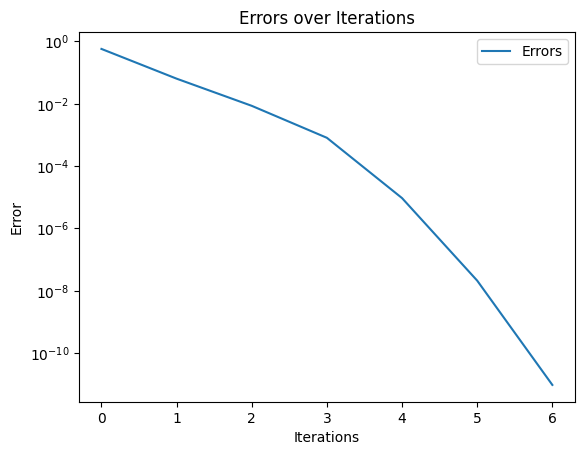

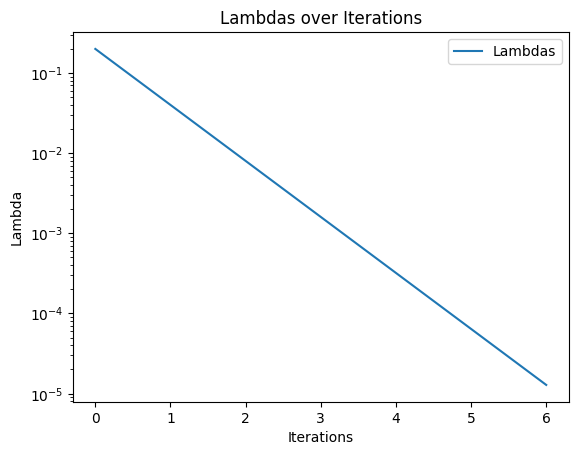

In [5]:
rank = 2
errors, lambdas, iters = [], [], []
new_cores = LM.CP(rank)
plot_errors()

In [6]:
def f(i, j, k, l, s):
    return np.sin(i + j + k + l + s)

sizes = (9, 27, 13, 11, 8)
T = np.fromfunction(f, sizes)

LM = LevenbergMarquardt(T)

Didn't onverged in 100 iterations. Relative error = 0.2089482151127374



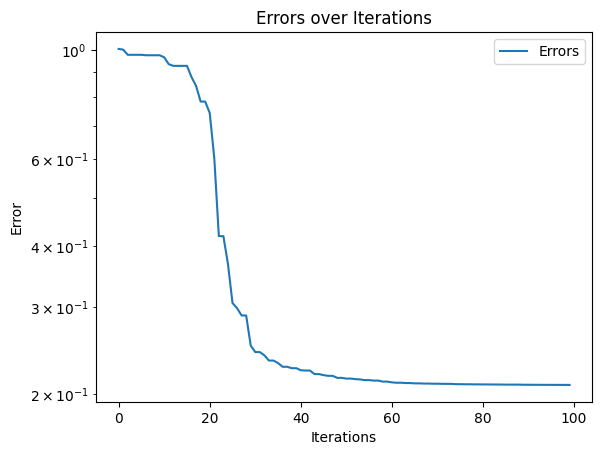

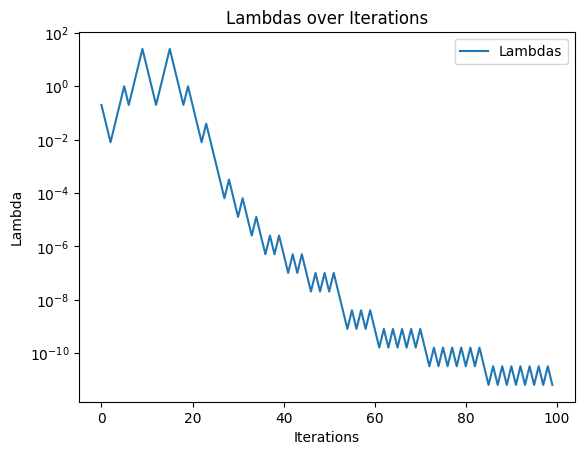

In [7]:
rank = 4
errors, lambdas, iters = [], [], []
new_cores = LM.CP(rank)
plot_errors()

Converged with error=4.892395436484784e-12 in 29 iterations



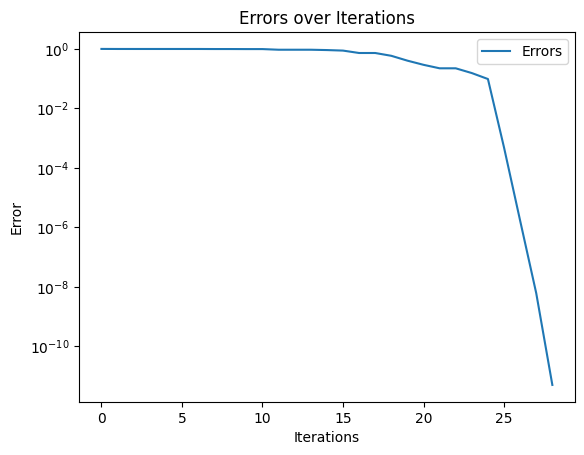

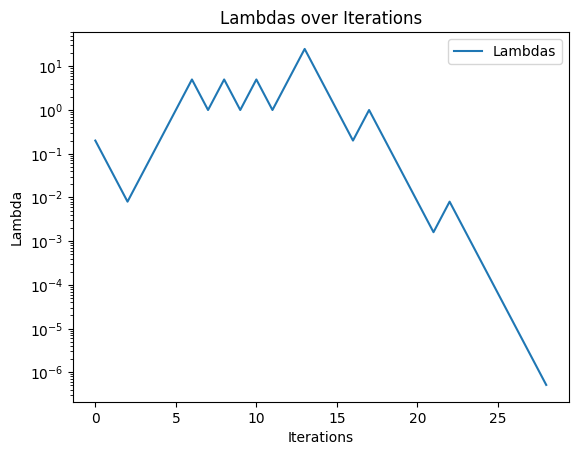

In [8]:
rank = 5
errors, lambdas, iters = [], [], []
new_cores = LM.CP(rank)
plot_errors()